<a href="https://colab.research.google.com/github/Rmejiaz/AnaliticadeDatos/blob/master/Fashion_MNIST_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de Datos - Clasificador de tipo de prenda y género del dataset Fashion MNIST utilizando redes neuronales

### Rafael Mejía Zuluaga
### rmejiaz@unal.edu.co

El objetivo es entrenar una red neuronal profunda con tres entradas y dos salidas. 

Entradas:

- Imágenes limpias
- Imágenes contaminadas con ruido blanco gaussiano   
    $\eta \sim \mathcal{N}\left(\eta|0,0.1\right)$
- Imágenes contaminadas con ruido sal y pimienta a un snr de 0.9

Salidas:

- Tipo de prenda (10 Clases)
- Genero (Femenino, Masculino o Unisex)

Se hicieron pruebas tanto con una red profunda simple como con una red convolucional.

Tensorflow 2.2.0
--2020-07-13 15:28:06--  https://docs.google.com/uc?export=download&confirm=&id=13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R
Resolving docs.google.com (docs.google.com)... 108.177.125.138, 108.177.125.101, 108.177.125.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-9c-docs.googleusercontent.com/docs/securesc/0ehq7llutp6omc9jrhvlbc01hjt0tjj1/uulltnsi085uhd16nm6lfssl2scr7al6/1594654050000/10854142796765961935/18334075742275603501Z/13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R?e=download [following]
--2020-07-13 15:28:07--  https://doc-0o-9c-docs.googleusercontent.com/docs/securesc/0ehq7llutp6omc9jrhvlbc01hjt0tjj1/uulltnsi085uhd16nm6lfssl2scr7al6/1594654050000/10854142796765961935/18334075742275603501Z/13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R?e=download
Resolving doc-0o-9c-docs.googleusercontent.com (doc-0o-9c-docs.googleusercontent.com)... 64.233.188.132, 2404:6800:4008:c

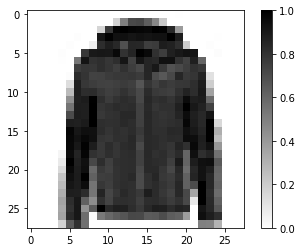

Labels: [0 1 2 3 4 5 6 7 8 9]
Dimentions: (60000, 28, 28)


In [ ]:
# Importar las librerías principales

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print("Tensorflow", tf.__version__)

# Decargar un .py con funciones 
FILEID = "13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O funciones.py && rm -rf /tmp/cookies.txt


# Descarga de la base de datos y visualización

train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train
images = images/255    # Se normalizan todos los datos 

plt.imshow(images[5000,:,:],cmap= 'binary')
plt.colorbar()
plt.show()

print("Labels:",np.unique(labels))
print("Dimentions:",images.shape)

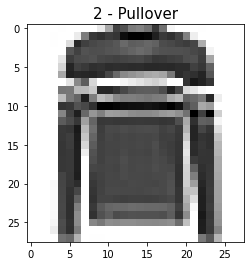

In [ ]:
Xtrain, ytrain = train
Xtrain = Xtrain/255 # tipo flotante, normalizados de 0 a 1
Xtest, ytest = test
Xtest = Xtest/255 # tipo flotante, normalizados de 0 a 1

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

title = str(ytrain[5])+' - '+str(class_names[ytrain[5]])
plt.imshow(Xtrain[5],cmap='binary')
plt.title(title,fontsize=15)
plt.show()

## Entradas y salidas extra

### Visualización de varias muestras de cada clase a la vez

In [ ]:
# Para visualizar varias muestras de cada cateogoría a la vez

from ipywidgets import interact

@interact(Tipo_Prenda=(0,9,1))
def fashion(Tipo_Prenda=0):
  n_rows = 8
  n_cols = 20
  plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
  for row in range(n_rows):
      for col in range(n_cols):
          index = n_cols * row + col
          plt.subplot(n_rows, n_cols, index + 1)
          plt.imshow(Xtrain[ytrain==Tipo_Prenda][index], cmap="binary", interpolation="nearest")
          plt.axis('off')
          plt.title(class_names[Tipo_Prenda], fontsize=12)
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  plt.show()

interactive(children=(IntSlider(value=0, description='Tipo_Prenda', max=9), Output()), _dom_classes=('widget-i…

### Salidas extra:

In [ ]:
# Para agregar la salida extra (B)
"""
 0 -> Unisex
 1 -> Femenino
 2 -> Masculino
"""

gender = ["Unisex","Femenino","Masculino"]

ytrainB = np.zeros(ytrain.shape[0])
ytestB = np.zeros(ytest.shape[0])

### Train
ytrainB[ytrain == 8] = 1  # Bag
ytrainB[ytrain == 3] = 1  # Dress
ytrainB[ytrain == 4] = 1  # Coat
ytrainB[ytrain == 5] = 1  # Sandal
ytrainB[ytrain == 9] = 1  # Ankle boot

### Test
ytestB[ytest == 8] = 1  # Bag
ytestB[ytest == 3] = 1  # Dress
ytestB[ytest == 4] = 1  # Coat
ytestB[ytest == 5] = 1  # Sandal
ytestB[ytest == 9] = 1  # Ankle boot


# Si bien existe la opción de tener prendas masculinas, en este caso todas son femeninas/unisex

### Entradas extra:

In [ ]:
#Agregar entrada ruido blanco gausiano
var = 0.1 #varianza ruido
XtrainB = Xtrain + np.sqrt(var)*np.random.randn(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2])
XtestB = Xtest + np.sqrt(var)*np.random.randn(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2])

#Agregar entrada con ruido sal y pimienta
def addsalt_pepper(img, SNR):
    Copy = img.copy()
    h, w = Copy.shape
    mask = np.random.choice((0, 1, 2), size=(Copy.shape[0],Copy.shape[1]), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    Copy[mask == 1] = 1 # salt noise
    Copy[mask == 2] = 0 # pepper noise 
    return Copy

def addsalt_pepper_v(a,SNR):
  VecC = np.zeros((a.shape[0],a.shape[1],a.shape[2]))
  for i in range(a.shape[0]):
    VecC[i] = addsalt_pepper(a[i],SNR)
  return VecC

XtrainC = addsalt_pepper_v(Xtrain,0.9)
XtestC = addsalt_pepper_v(Xtest,0.9)

## Ejemplo entradas y salidas:

Inputs:


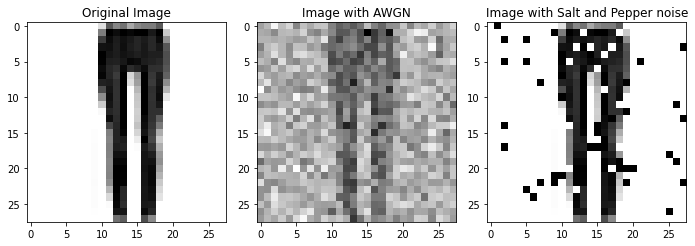

Outputs:
1 - Trouser
0.0 - Unisex


In [ ]:
#Ejemplo de las 3 entradas con las 2 salidas

sample = 103

print("Inputs:")

fig, ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(Xtrain[sample],cmap='binary')
ax[0].set_title("Original Image")
ax[1].imshow(XtrainB[sample],cmap='binary')
ax[1].set_title("Image with AWGN")
ax[2].imshow(XtrainC[sample],cmap='binary')
ax[2].set_title("Image with Salt and Pepper noise")
plt.tight_layout()
plt.show()


print("Outputs:")
print(ytrain[sample],"-",class_names[ytrain[sample]] )
print(ytrainB[sample], "-", gender[int(ytrainB[sample])])

# Red Neuronal Profunda

## Entrenamiento y validación

Hacemos validación con un subconjunto del conjunto de train del 30%

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaA (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
entradaB (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
entradaC (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           entradaA[0][0]                   
______________________________________________________________________________________________

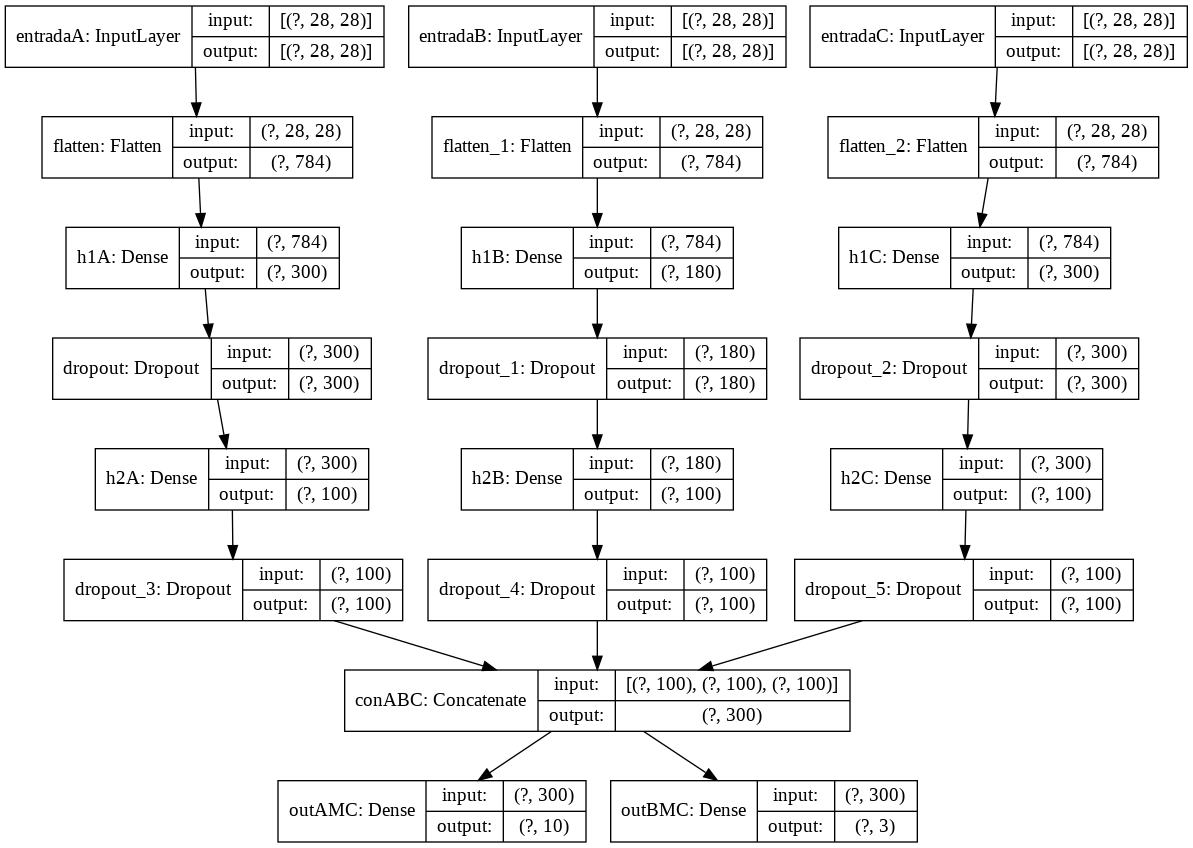

In [ ]:
tf.keras.backend.clear_session()


#Entradas
inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entradaA')
inputB = tf.keras.layers.Input(shape=(XtrainB.shape[1],XtrainB.shape[2]), name='entradaB')
inputC = tf.keras.layers.Input(shape=(XtrainC.shape[1],XtrainC.shape[2]), name='entradaC')


#Luego de realizar pruebas, esta fue una de las mejores combinaciones de numero de capas, número de neuronas por capa y regularizacones

Q1 = 300
Q2 = 100
l1 = 1e-4
l2 = 1e-4

flattenA = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(inputA)
flattenB = tf.keras.layers.Flatten(input_shape=(XtrainB.shape[1],XtrainB.shape[2]))(inputB)
flattenC = tf.keras.layers.Flatten(input_shape=(XtrainC.shape[1],XtrainC.shape[2]))(inputC)


h1A = tf.keras.layers.Dense(Q1,activation='relu',name='h1A',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenA)

drop_1A = tf.keras.layers.Dropout(0.3)(h1A) # Evitar overfitting
h1B = tf.keras.layers.Dense(180,activation='relu',name='h1B',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenB)
drop_1B = tf.keras.layers.Dropout(0.3)(h1B) # Evitar overfitting

h1C = tf.keras.layers.Dense(Q1,activation='relu',name='h1C',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenC)

drop_1C = tf.keras.layers.Dropout(0.3)(h1C) # Estresar el modelo y evitar overfitting

h2A = tf.keras.layers.Dense(Q2,activation='relu',name='h2A',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(drop_1A)
drop_2A = tf.keras.layers.Dropout(0.3)(h2A) # Evitar overfitting
h2B = tf.keras.layers.Dense(Q2,activation='relu',name='h2B',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(drop_1B)
drop_2B = tf.keras.layers.Dropout(0.3)(h2B) # Evitar overfitting
h2C = tf.keras.layers.Dense(Q2,activation='relu',name='h2C',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(drop_1C)
drop_2C = tf.keras.layers.Dropout(0.3)(h2C) # Evitar overfitting

concABC = tf.keras.layers.concatenate([drop_2A,drop_2B,drop_2C],name='conABC')

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outAMC')(concABC) #salida tipo de prenda (multiclase)
outputB = tf.keras.layers.Dense(3,activation="softmax",name='outBMC')(concABC) #salida genero (multiclase)            # Las funciones de activación de ambas salidas es softmax, ya que las dos son multiclase
model = tf.keras.Model(inputs=[inputA,inputB,inputC],outputs=[outputA,outputB])
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(loss=["sparse_categorical_crossentropy","sparse_categorical_crossentropy"],  # Se utiliza esta función de costo ya que las salidas son multiclase y no están etiquetadas en OneHot
              loss_weights = [0.5,0.5],   # Damos la misma importancia a las dos salidas
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) 
history = model.fit(x =[Xtrain,XtrainB,XtrainC], y=[ytrain,ytrainB], 
                        epochs=20, batch_size = 64, 
                         validation_split=0.3)

Epoch 1/20
657/657 [==============================] - 10s 15ms/step - loss: 1.6836 - outAMC_loss: 0.6743 - outBMC_loss: 0.3323 - outAMC_accuracy: 0.7613 - outBMC_accuracy: 0.8514 - val_loss: 0.8740 - val_outAMC_loss: 0.4976 - val_outBMC_loss: 0.2398 - val_outAMC_accuracy: 0.8244 - val_outBMC_accuracy: 0.9019
Epoch 2/20
657/657 [==============================] - 10s 15ms/step - loss: 0.7680 - outAMC_loss: 0.5349 - outBMC_loss: 0.2647 - outAMC_accuracy: 0.8104 - outBMC_accuracy: 0.8899 - val_loss: 0.6288 - val_outAMC_loss: 0.4587 - val_outBMC_loss: 0.2335 - val_outAMC_accuracy: 0.8364 - val_outBMC_accuracy: 0.9026
Epoch 3/20
657/657 [==============================] - 9s 14ms/step - loss: 0.6126 - outAMC_loss: 0.5014 - outBMC_loss: 0.2417 - outAMC_accuracy: 0.8227 - outBMC_accuracy: 0.9007 - val_loss: 0.5688 - val_outAMC_loss: 0.4671 - val_outBMC_loss: 0.2408 - val_outAMC_accuracy: 0.8283 - val_outBMC_accuracy: 0.9004
Epoch 4/20
657/657 [==============================] - 10s 15ms/step - l

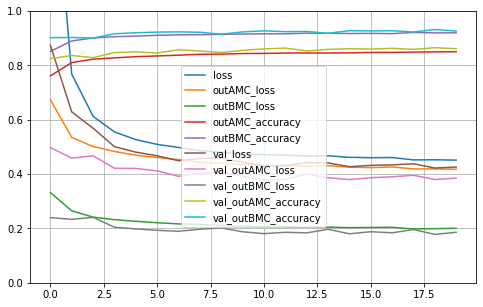

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

# Evaluación

Hacemos la evaluación sobre el conjunto de test

In [ ]:
model.evaluate(x=[Xtest,XtestB,XtestC],y=[ytest,ytestB])

313/313 [==============================] - 1s 4ms/step - loss: 0.4468 - outAMC_loss: 0.4155 - outBMC_loss: 0.1973 - outAMC_accuracy: 0.8499 - outBMC_accuracy: 0.9218


[0.4468040466308594,
 0.41550055146217346,
 0.1972978711128235,
 0.8499000072479248,
 0.9218000173568726]

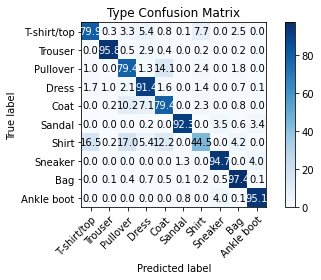

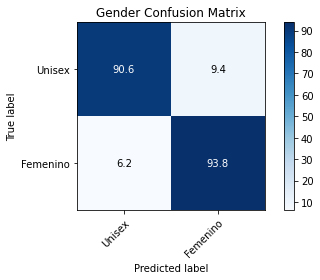

In [ ]:
from funciones import plot_confusion_matrix


y_est, yB_est = model.predict([Xtest,XtestB,XtestC])

plot_confusion_matrix(ytest,y_est.argmax(axis=1),classes=class_names,title='Type Confusion Matrix')
plt.show()

plot_confusion_matrix(ytestB,yB_est.argmax(axis=1),classes=gender,title='Gender Confusion Matrix')
plt.show()

La categoría que peor rendimiento tuvo según la matriz de confusión fue la de Shirt, pues esta se puede confundir fácilmente con T-shirt/top o con Pullover

## Pesos primeras capas:

Orignal Images - Images with AWGN - Images with salt and pepper noise


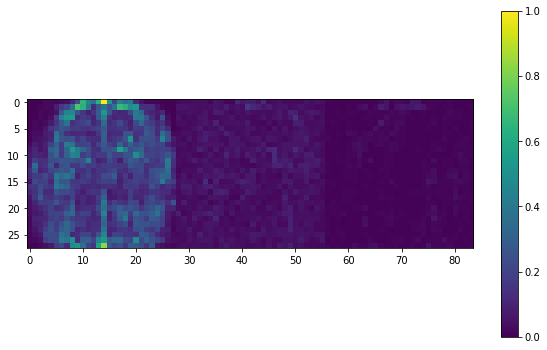

In [ ]:
W1 = abs(model.get_layer('h1A').get_weights()[0]).sum(axis=1).reshape(Xtest.shape[1],Xtest.shape[2])
W2 = abs(model.get_layer('h1B').get_weights()[0]).sum(axis=1).reshape(Xtest.shape[1],Xtest.shape[2])
W3 = abs(model.get_layer('h1C').get_weights()[0]).sum(axis=1).reshape(Xtest.shape[1],Xtest.shape[2])

Wc = np.c_[W1,W2,W3]
Wc /=np.max(Wc)
print("Orignal Images - Images with AWGN - Images with salt and pepper noise")
plt.figure(figsize=(10,6))
plt.imshow(Wc,vmin=0,vmax=1)
plt.colorbar()
plt.show()

Como se puede ver, la red le da más importania a la entrada de las imágenes limpias, lo cual es deseable pues éstas son las que más información contienen

## Evaluación de etapas intermedias (visualización utilizando PCA):

In [ ]:
from sklearn.decomposition import PCA

### Capa h1A
model_h1A = tf.keras.Model(inputs=[inputA],outputs=model.get_layer('h1A').output)
h1AOut = model_h1A.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
red1 = PCA()
zh1AOut = red1.fit_transform(h1AOut) 

### Capa h2A

model_h2A = tf.keras.Model(inputs=[inputA],outputs=model.get_layer('h2A').output)
h2AOut = model_h2A.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
red2 = PCA()
zh2AOut = red2.fit_transform(h2AOut)


### Capa h1B
model_h1B = tf.keras.Model(inputs=[inputB],outputs=model.get_layer('h1B').output)
h1BOut = model_h1B.predict(XtrainB)
#tf.keras.utils.plot_model(model_h1A)
red3 = PCA()
zh1BOut = red1.fit_transform(h1BOut) 

### Capa h2B

model_h2B = tf.keras.Model(inputs=[inputB],outputs=model.get_layer('h2B').output)
h2BOut = model_h2B.predict(XtrainB)
#tf.keras.utils.plot_model(model_h1A)
red4 = PCA()
zh2BOut = red2.fit_transform(h2BOut)


### Capa h1C
model_h1C = tf.keras.Model(inputs=[inputC],outputs=model.get_layer('h1C').output)
h1COut = model_h1C.predict(XtrainC)
#tf.keras.utils.plot_model(model_h1A)
red5 = PCA()
zh1COut = red1.fit_transform(h1COut) 

### Capa h2C

model_h2C = tf.keras.Model(inputs=[inputC],outputs=model.get_layer('h2C').output)
h2COut = model_h2C.predict(XtrainC)
#tf.keras.utils.plot_model(model_h1A)
red4 = PCA()
zh2COut = red2.fit_transform(h2COut)


model_out = tf.keras.Model(inputs=[inputA,inputB,inputC],outputs=model.get_layer('conABC').output)
Out_ = model_out.predict([Xtrain,XtrainB,XtrainC])
#tf.keras.utils.plot_model(model_h1A)
red5 = PCA()
zOut = red5.fit_transform(Out_)

In [ ]:
def int_layers(ytrain):
  plt.figure(figsize=(16,9),dpi=90)

  grid = plt.GridSpec(4, 3, wspace=0.3, hspace=0.4)

  plt.subplot(grid[0, 0])
  plt.scatter(zh1AOut[:,0],zh1AOut[:,1],c=ytrain)
  plt.title("Layer h1A")
  plt.colorbar()

  plt.subplot(grid[1, 0])
  plt.scatter(zh2AOut[:,0],zh2AOut[:,1],c=ytrain)
  plt.title("Layer h2A")
  plt.colorbar()

  plt.subplot(grid[0, 1])
  plt.scatter(zh1BOut[:,0],zh1BOut[:,1],c=ytrain)
  plt.title("Layer h1B")
  plt.colorbar()

  plt.subplot(grid[1, 1])
  plt.scatter(zh2BOut[:,0],zh2BOut[:,1],c=ytrain)
  plt.title("Layer h2B")
  plt.colorbar()

  plt.subplot(grid[0, 2])
  plt.scatter(zh1COut[:,0],zh1COut[:,1],c=ytrain)
  plt.title("Layer h1C")
  plt.colorbar()

  plt.subplot(grid[1, 2])
  plt.scatter(zh2COut[:,0],zh2COut[:,1],c=ytrain)
  plt.title("Layer h2C")
  plt.colorbar()
  #plt.tight_layout()

  plt.subplot(grid[2:,0:])
  plt.scatter(zOut[:,0],zOut[:,1],c=ytrain)
  plt.title("Decision Space")
  plt.colorbar()

  plt.show()

## Para el tipo de prenda:

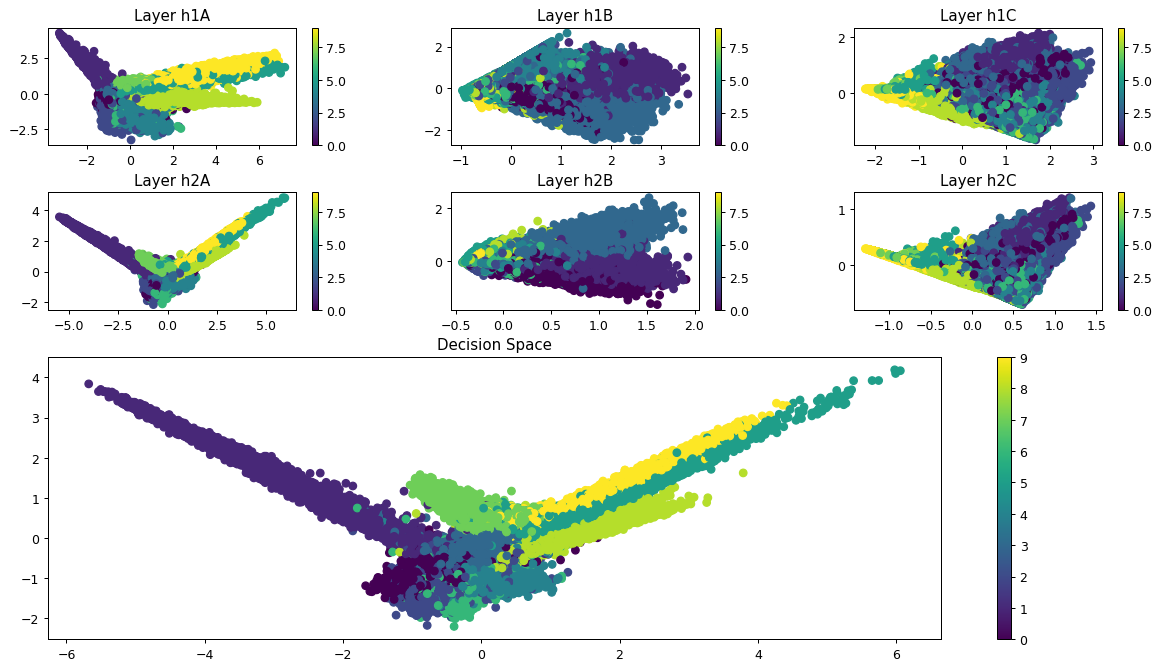

In [ ]:
int_layers(ytrain)

La proyección de la últiuma capa permite ver como, clases como Bag (8) o Trouser (1) quedan muy bien separadas de otras clases mientras que hay zonas en las que hay clases muy mezcladas, como lo son T-Shirt/top, Pullover y Shirt (0, 2, 6 respectivamente) lo cual tiene sentido, ya que son prendas muy similares en forma. 

## Para el genero:

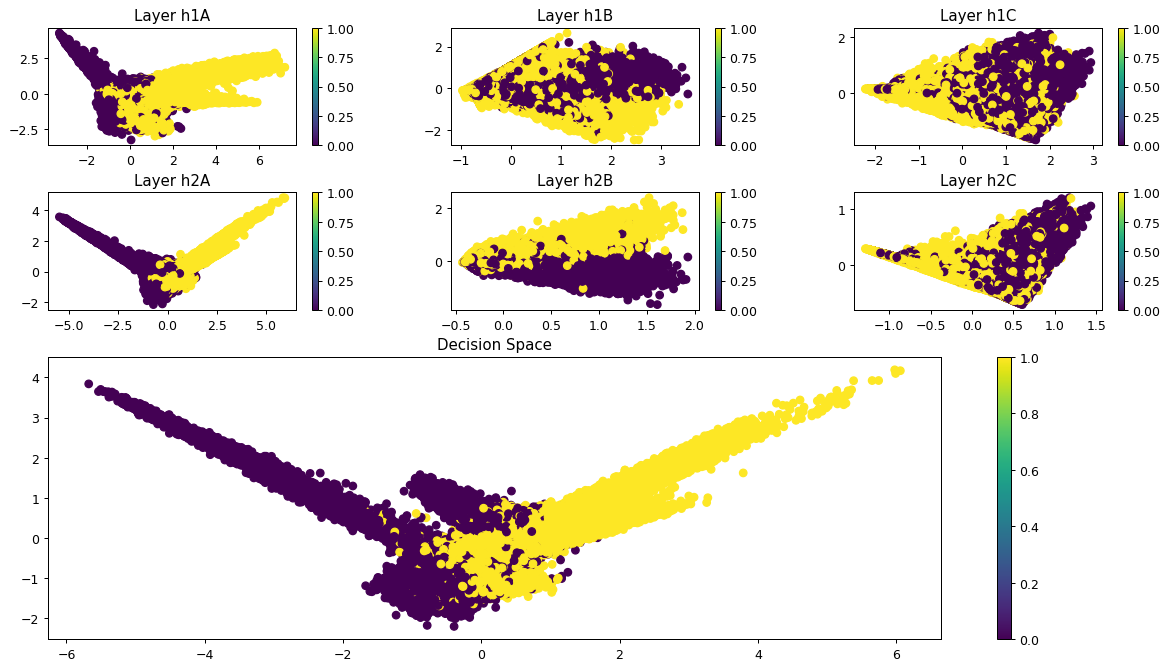

In [ ]:
int_layers(ytrainB)

En general la red hace un buen trabajo separando las diferentes clases, tal como podemos ver de la proyección de la salida de la capa de concatenación (capa sobre la cual el modelo clasifica) Sin embargo, siguen habiendo zonas en las que no es fácil hacer una predicción.

# Red Convolucional

Ahora probamos la red poniendo antes unas capas de filtrado y de pooling para extraer más caracteríticas. Las redes convolucionales son la arquitectura predilecta para porblemas de visión, pues estas permiten interpretar patrones más complejos dando más importancia a la cercanía entre los diferentes píxeles, a diferencia de las redes profundas, en las cuales todos los pixeles tienen la misma importancia.

Las primeras capas corresponden a varias convoluciones, y de ahí en adelante se utiliza una arqutectura muy similar a la que se trabajó anteriormente (dos capas densas)

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaA (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
entradaB (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
entradaC (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 28, 28, 64)   3200        entradaA[0][0]                   
___________________________________________________________________________________________

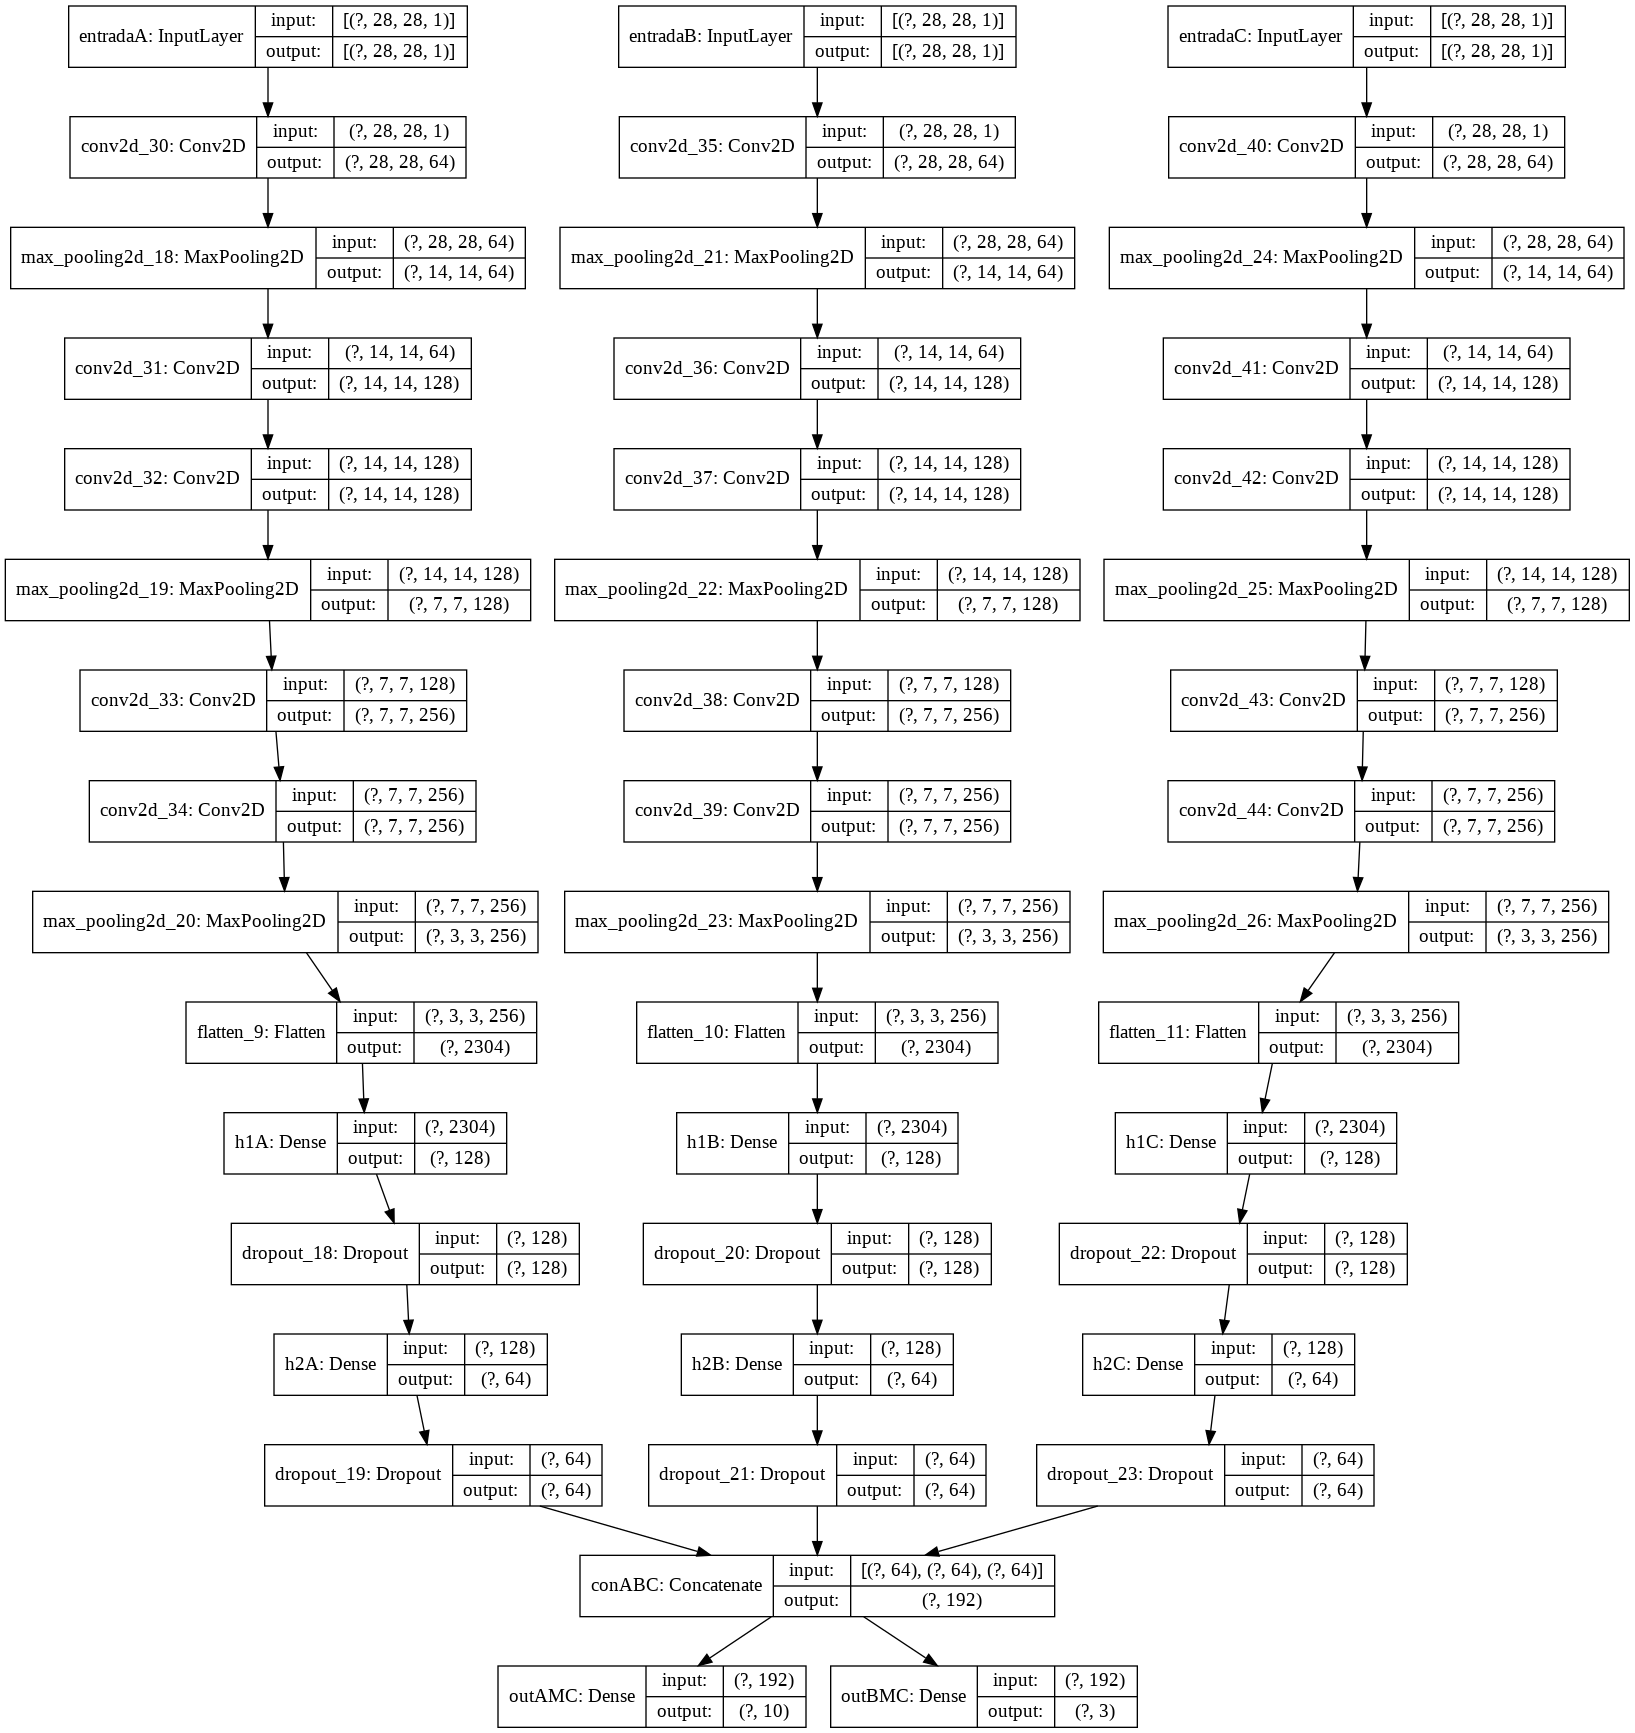

In [ ]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2],1),name = 'entradaA')
c_layer1A = DefaultConv2D(filters=64, kernel_size=7, input_shape=[Xtrain.shape[1], Xtrain.shape[2], 1])(inputA)
pooling1A = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer1A)
c_layer2A = DefaultConv2D(filters=128)(pooling1A)
c_layer3A = DefaultConv2D(filters=128)(c_layer2A)
pooling2A = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer3A)
c_layer4A = DefaultConv2D(filters=256)(pooling2A)
c_layer5A = DefaultConv2D(filters=256)(c_layer4A)
pooling3A = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer5A)
flattenA = tf.keras.layers.Flatten()(pooling3A)
h1A = tf.keras.layers.Dense(units=128, activation='relu',name='h1A')(flattenA)
dropout1A = tf.keras.layers.Dropout(0.5)(h1A)
h2A = tf.keras.layers.Dense(units=64, activation='relu',name='h2A')(dropout1A)
dropout2A = tf.keras.layers.Dropout(0.5)(h2A)




inputB = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2],1),name = 'entradaB')
c_layer1B = DefaultConv2D(filters=64, kernel_size=7, input_shape=[Xtrain.shape[1], Xtrain.shape[2], 1])(inputB)
pooling1B = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer1B)
c_layer2B = DefaultConv2D(filters=128)(pooling1B)
c_layer3B = DefaultConv2D(filters=128)(c_layer2B)
pooling2B = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer3B)
c_layer4B = DefaultConv2D(filters=256)(pooling2B)
c_layer5B = DefaultConv2D(filters=256)(c_layer4B)
pooling3B = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer5B)
flattenB = tf.keras.layers.Flatten()(pooling3B)
h1B = tf.keras.layers.Dense(units=128, activation='relu',name='h1B')(flattenB)
dropout1B = tf.keras.layers.Dropout(0.5)(h1B)
h2B = tf.keras.layers.Dense(units=64, activation='relu',name='h2B')(dropout1B)
dropout2B = tf.keras.layers.Dropout(0.5)(h2B)



inputC = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2],1),name = 'entradaC')
c_layer1C = DefaultConv2D(filters=64, kernel_size=7, input_shape=[Xtrain.shape[1], Xtrain.shape[2], 1])(inputC)
pooling1C = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer1C)
c_layer2C = DefaultConv2D(filters=128)(pooling1C)
c_layer3C = DefaultConv2D(filters=128)(c_layer2C)
pooling2C = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer3C)
c_layer4C = DefaultConv2D(filters=256)(pooling2C)
c_layer5C = DefaultConv2D(filters=256)(c_layer4C)
pooling3C = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer5C)
flattenC = tf.keras.layers.Flatten()(pooling3C)
h1C = tf.keras.layers.Dense(units=128, activation='relu',name='h1C')(flattenC)
dropout1C = tf.keras.layers.Dropout(0.5)(h1C)
h2C = tf.keras.layers.Dense(units=64, activation='relu',name='h2C')(dropout1C)
dropout2C = tf.keras.layers.Dropout(0.5)(h2C)

conABC = tf.keras.layers.concatenate([dropout2A,dropout2B,dropout2C],name='conABC')

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outAMC')(conABC) #salida tipo de prenda (multiclase)
outputB = tf.keras.layers.Dense(3,activation="softmax",name='outBMC')(conABC) #salida genero (multiclase)


CNNmodel = tf.keras.Model(inputs=[inputA,inputB,inputC],outputs=[outputA,outputB])

CNNmodel.summary()
tf.keras.utils.plot_model(CNNmodel,show_shapes=True)


In [ ]:
CNNmodel.compile(loss=["sparse_categorical_crossentropy","sparse_categorical_crossentropy"], 
              loss_weights = [0.5,0.5],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) 
history = CNNmodel.fit(x =[Xtrain,XtrainB,XtrainC], y=[ytrain,ytrainB], 
                        epochs=15, batch_size = 64,
                         validation_split=0.3)

Epoch 1/15
657/657 [==============================] - 49s 75ms/step - loss: 0.5920 - outAMC_loss: 0.8339 - outBMC_loss: 0.3502 - outAMC_accuracy: 0.6992 - outBMC_accuracy: 0.8392 - val_loss: 0.3374 - val_outAMC_loss: 0.4566 - val_outBMC_loss: 0.2181 - val_outAMC_accuracy: 0.8403 - val_outBMC_accuracy: 0.9005
Epoch 2/15
657/657 [==============================] - 49s 74ms/step - loss: 0.3264 - outAMC_loss: 0.4561 - outBMC_loss: 0.1967 - outAMC_accuracy: 0.8440 - outBMC_accuracy: 0.9218 - val_loss: 0.2738 - val_outAMC_loss: 0.3764 - val_outBMC_loss: 0.1712 - val_outAMC_accuracy: 0.8620 - val_outBMC_accuracy: 0.9303
Epoch 3/15
657/657 [==============================] - 49s 74ms/step - loss: 0.2727 - outAMC_loss: 0.3800 - outBMC_loss: 0.1654 - outAMC_accuracy: 0.8680 - outBMC_accuracy: 0.9365 - val_loss: 0.2423 - val_outAMC_loss: 0.3347 - val_outBMC_loss: 0.1499 - val_outAMC_accuracy: 0.8801 - val_outBMC_accuracy: 0.9418
Epoch 4/15
657/657 [==============================] - 49s 74ms/step - 

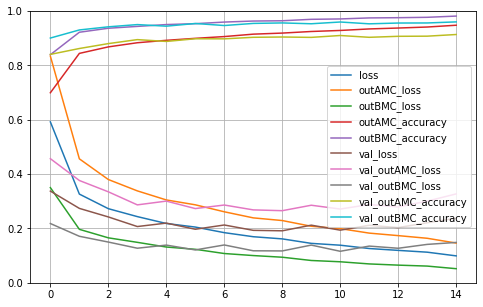

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
CNNmodel.evaluate(x=[Xtest,XtestB,XtestC],y=[ytest,ytestB])

313/313 [==============================] - 5s 16ms/step - loss: 0.2650 - outAMC_loss: 0.3636 - outBMC_loss: 0.1664 - outAMC_accuracy: 0.9045 - outBMC_accuracy: 0.9533


[0.26497986912727356,
 0.3635924756526947,
 0.1663673371076584,
 0.9045000076293945,
 0.9532999992370605]

Se logró un aumento importante en la exactitud del modelo. Pasamos de 85% y 92% a 90% y 95% respectivamente 

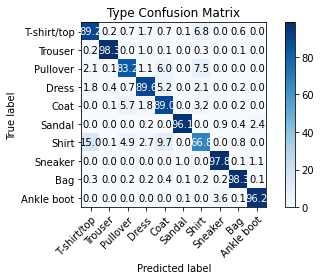

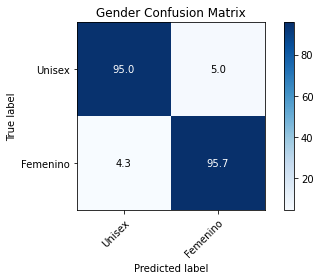

In [ ]:
from funciones import plot_confusion_matrix


y_est, yB_est = CNNmodel.predict([Xtest,XtestB,XtestC])

plot_confusion_matrix(ytest,y_est.argmax(axis=1),classes=class_names,title='Type Confusion Matrix')
plt.show()

plot_confusion_matrix(ytestB,yB_est.argmax(axis=1),classes=gender,title='Gender Confusion Matrix')
plt.show()

Según la matriz de confusión de los tipos de prenda, donde el modelo más dificultad tuvo fue distinguendo entre Shirt y T-Shirt/Top y Pullover y Coat, lo cual es razonable, pues son prendas muy similares. Por otro lado, clases como Trouser y Bag no reprenstaron mayor problema, pues estos no tienen similtud con ninguna otra clase

Como era de esperar, con la red convolucional se obtienen resultados significativamente mejores, tal como lo demuestran el accuracy y las matrices de confusión

## Evaluación de etapas intermedias (visualización utilizando PCA):

In [ ]:
from sklearn.decomposition import PCA

### Capa h1A
model_h1A = tf.keras.Model(inputs=[inputA],outputs=CNNmodel.get_layer('h1A').output)
h1AOut = model_h1A.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
red1 = PCA()
zh1AOut = red1.fit_transform(h1AOut) 

### Capa h2A

model_h2A = tf.keras.Model(inputs=[inputA],outputs=CNNmodel.get_layer('h2A').output)
h2AOut = model_h2A.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
red2 = PCA()
zh2AOut = red2.fit_transform(h2AOut)


### Capa h1B
model_h1B = tf.keras.Model(inputs=[inputB],outputs=CNNmodel.get_layer('h1B').output)
h1BOut = model_h1B.predict(XtrainB)
#tf.keras.utils.plot_model(model_h1A)
red3 = PCA()
zh1BOut = red1.fit_transform(h1BOut) 

### Capa h2B

model_h2B = tf.keras.Model(inputs=[inputB],outputs=CNNmodel.get_layer('h2B').output)
h2BOut = model_h2B.predict(XtrainB)
#tf.keras.utils.plot_model(model_h1A)
red4 = PCA()
zh2BOut = red2.fit_transform(h2BOut)


### Capa h1C
model_h1C = tf.keras.Model(inputs=[inputC],outputs=CNNmodel.get_layer('h1C').output)
h1COut = model_h1C.predict(XtrainC)
#tf.keras.utils.plot_model(model_h1A)
red5 = PCA()
zh1COut = red1.fit_transform(h1COut) 

### Capa h2C

model_h2C = tf.keras.Model(inputs=[inputC],outputs=CNNmodel.get_layer('h2C').output)
h2COut = model_h2C.predict(XtrainC)
#tf.keras.utils.plot_model(model_h1A)
red4 = PCA()
zh2COut = red2.fit_transform(h2COut)


model_out = tf.keras.Model(inputs=[inputA,inputB,inputC],outputs=CNNmodel.get_layer('conABC').output)
Out_ = model_out.predict([Xtrain,XtrainB,XtrainC])
#tf.keras.utils.plot_model(model_h1A)
red5 = PCA()
zOut = red5.fit_transform(Out_)

In [ ]:
def int_layers(ytrain):
  plt.figure(figsize=(16,9),dpi=90)

  grid = plt.GridSpec(4, 3, wspace=0.3, hspace=0.4)

  plt.subplot(grid[0, 0])
  plt.scatter(zh1AOut[:,0],zh1AOut[:,1],c=ytrain)
  plt.title("Layer h1A")
  plt.colorbar()

  plt.subplot(grid[1, 0])
  plt.scatter(zh2AOut[:,0],zh2AOut[:,1],c=ytrain)
  plt.title("Layer h2A")
  plt.colorbar()

  plt.subplot(grid[0, 1])
  plt.scatter(zh1BOut[:,0],zh1BOut[:,1],c=ytrain)
  plt.title("Layer h1B")
  plt.colorbar()

  plt.subplot(grid[1, 1])
  plt.scatter(zh2BOut[:,0],zh2BOut[:,1],c=ytrain)
  plt.title("Layer h2B")
  plt.colorbar()

  plt.subplot(grid[0, 2])
  plt.scatter(zh1COut[:,0],zh1COut[:,1],c=ytrain)
  plt.title("Layer h1C")
  plt.colorbar()

  plt.subplot(grid[1, 2])
  plt.scatter(zh2COut[:,0],zh2COut[:,1],c=ytrain)
  plt.title("Layer h2C")
  plt.colorbar()
  #plt.tight_layout()

  plt.subplot(grid[2:,0:])
  plt.scatter(zOut[:,0],zOut[:,1],c=ytrain)
  plt.title("Decision Space")
  plt.colorbar()

  plt.show()

## Para el tipo de prenda:

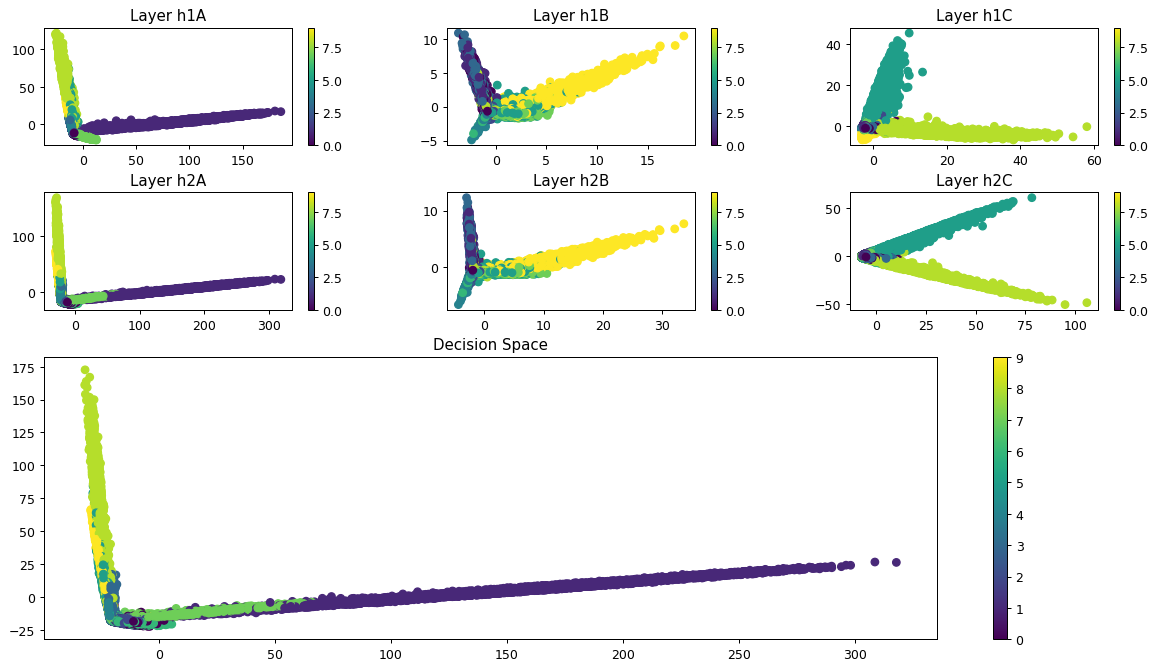

In [ ]:
int_layers(ytrain)

Si bien hay muchas clases que parecen estar superpuestas con otras, hay que tener en mente que esta es una proyección de un espacio de 192 dimensiones, por lo que es muy probable que en realidad las clases estén muy bien separdas, como lo demuestran la exactitud (accuracy) y la matriz de confusión 

## Para el genero:

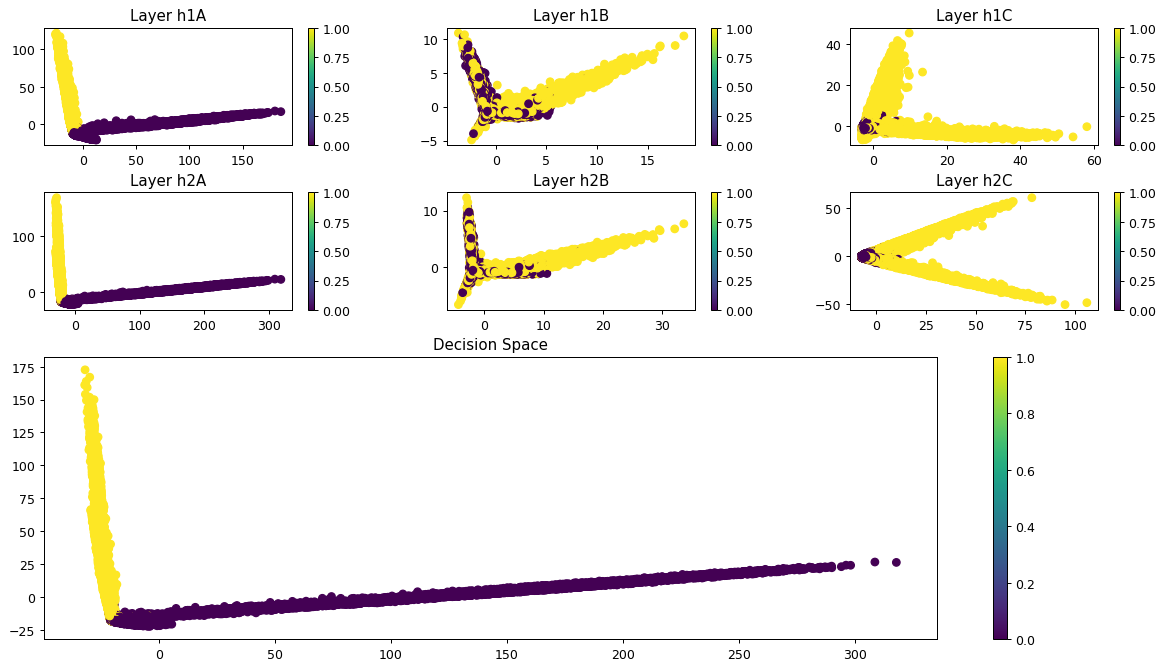

In [ ]:
int_layers(ytrainB)

En el caso de los géneros, es evidente que el modelo hizo un trabajo muy bueno, pues podemos observar una separación casi perfecta en el espacio de desición.

Como podemos ver, la red neuronal convolucional hizo un mucho mejor trabajo separando las diferentes clases. Por otro lado, también es evidente que el problema del genero es mucho más sencillo que el de tipo de prenda

# Ejemplo modelo funcionando:

Inputs:


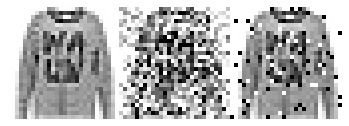

Predicted outputs:  Pullover - Unisex


In [ ]:
ii = 500

pe,peb = CNNmodel.predict([Xtest[ii][np.newaxis,:,:],XtestB[ii][np.newaxis,:,:],XtestC[ii][np.newaxis,:,:]])

print("Inputs:")
plt.imshow(np.c_[Xtest[ii],XtestB[ii],XtestC[ii]],cmap='binary',vmin=0,vmax=1)
plt.axis('off')
plt.show()

print("Predicted outputs: ",class_names[pe.argmax()],"-",gender[int(np.arange(3).dot(np.round(peb).T)[0])])


## Salida de la primera convolución:

In [ ]:
PartMod1 = tf.keras.Model(inputs=[inputA],outputs=c_layer1A)
conv1out = PartMod1.predict(Xtest[500][np.newaxis,:,:])

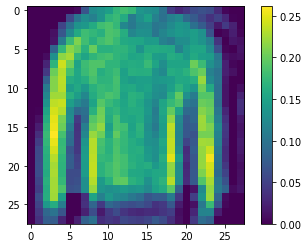

In [ ]:
plt.imshow(partout[0,:,:,-1])
plt.colorbar()
plt.show()

La información más relevante que extrajo la primera convoluión de la imagen en cuestión. Es claro que se identificó muy bien la forma de la prenda, con especial énfasis en las mangas. Posiblemente para distinguir entre los sacos de las camisetas.